In [118]:
import os
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling import models, fitting
import numpy 
from scipy import optimize
from matplotlib import pyplot
%matplotlib inline
#%matplotlib notebook
import aplpy



<h2> Open data file 

In [119]:
#ROOTfile = "./release_galactic_skymap_fixed_head.fits"
ROOTfile = "./SgrA_galactic_uncorrelated_excess_map_fixedhead.fits"
HDUlist = fits.open(ROOTfile)
HDUlist.info()
gal_wcs = WCS(HDUlist[0].header)
print(gal_wcs)
HDUlist.close()


Filename: ./SgrA_galactic_uncorrelated_excess_map_fixedhead.fits
No.    Name         Type      Cards   Dimensions   Format
0    UncorrelatedExcess  PrimaryHDU      16   (240, 240)   float32   
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN'  'GLAT-TAN'  
CRVAL : 359.94420870804902  -0.0460128714594389  
CRPIX : 120.0  120.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.025000000000000001  0.025000000000000001  
NAXIS    : 240 240


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.
/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


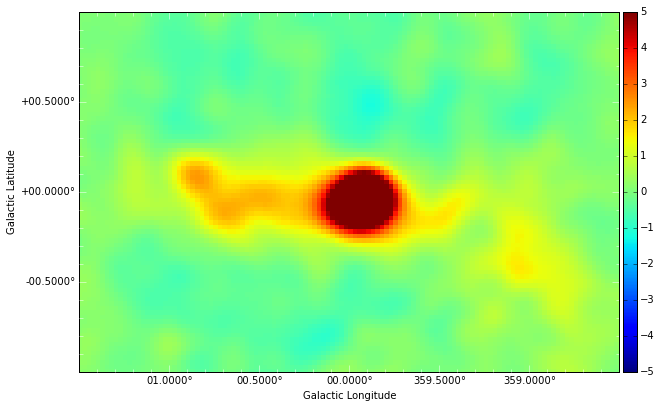

In [120]:
fig_apl = aplpy.FITSFigure(ROOTfile)
#fig_apl.show_colorscale( smooth=3, vmin=-5., vmax=5.) #cmap='hot',

col_bar = fig_apl.show_colorbar()
#fig_apl.recenter(0., 0., width=3., height=2.)

#col_bar


In [121]:
excess_data, skymap_header = fits.getdata(ROOTfile, header = True)

excess_data_N = numpy.nan_to_num(excess_data) # rm nan's for fitting 


In [122]:

#print(skymap_header)
# G0.9+0.1
#print(excess_data_N[121:123,83:85])
#numpy.where(excess_data_N > 100)
# looks like the x/y axes are flipped, and there is a shift of 1 vs ds9


<h2> Create coordinate arrays

In [123]:
x_bins = excess_data.shape[0]
y_bins = excess_data.shape[1]

# Create x and y indices
x = numpy.linspace(0, x_bins-1, x_bins)
y = numpy.linspace(0, y_bins-1, y_bins)
x, y = numpy.meshgrid(x, y)
coords = x, y

x_world, y_world = fig_apl.pixel2world(x,y)
coords_world = x_world, y_world

print(fig_apl.world2pixel(359.944,-0.046)) #SgrA
print(fig_apl.world2pixel(0.050,-0.150)) #J1746
print(fig_apl.world2pixel(.87,.08)) #G09


(120.00834831926974, 120.00051485836507)
(115.76835104537822, 115.84050006370752)
(82.965071714460734, 125.04094076750306)


<h2> Fitting Central Gaussian


In [133]:
SgrA_bounds = {'amplitude':(10,75), 'x_mean':(119,121), 'y_mean':(119,121), 'x_stddev':(0.25,3.), 'y_stddev':(0.25,3.), 'theta':(-1.,1.)}
SgrA_gauss = models.Gaussian2D(amplitude=30, x_mean=120, y_mean=120, x_stddev=1, y_stddev=1, theta=0, bounds=SgrA_bounds)
SgrA_bounds_2 = {'amplitude':(0.,25.), 'x_mean':(119,121), 'y_mean':(119,121), 'x_stddev':(3,10), 'y_stddev':(3,10), 'theta':(-1.,1.)}
SgrA_gauss_2 = models.Gaussian2D(amplitude=10, x_mean=120, y_mean=120, x_stddev=3, y_stddev=3, theta=0, bounds=SgrA_bounds_2)
J1746_bounds = {'amplitude':(5,15), 'x_mean':(115,117), 'y_mean':(115,117), 'x_stddev':(3,10), 'y_stddev':(3,10), 'theta':(-1.,1.)}
J1746_gauss = models.Gaussian2D(amplitude=10, x_mean=116, y_mean=116, x_stddev=3, y_stddev=3, theta=0, bounds=J1746_bounds)
sum_gauss = SgrA_gauss + SgrA_gauss_2 + J1746_gauss


In [134]:
fit_p = fitting.LevMarLSQFitter()
fit_gauss = fit_p(sum_gauss, x, y, excess_data_N, maxiter=5000)
# try to add in sigma, or do this with curve_fit 

for i in range(0,len(fit_gauss.parameters)):
    paramline = fit_gauss.param_names[i] + ": " + str(fit_gauss.parameters[i])
    print(paramline)


amplitude_0: 34.588952332
x_mean_0: 120.15161081
y_mean_0: 119.250931146
x_stddev_0: 1.97346044478
y_stddev_0: 2.07791146282
theta_0: -1.0
amplitude_1: 4.38247771279
x_mean_1: 121.0
y_mean_1: 119.0
x_stddev_1: 10.0
y_stddev_1: 3.0
theta_1: -0.139425938354
amplitude_2: 5.0
x_mean_2: 115.0
y_mean_2: 117.0
x_stddev_2: 4.1051940876
y_stddev_2: 5.41531102346
theta_2: -1.0


In [135]:
SgrA_double = SgrA_gauss + SgrA_gauss_2
fit_SgrA = fitting.LevMarLSQFitter()
SgrA_fit = fit_SgrA(SgrA_gauss, x, y, excess_data_N, maxiter=2500)

print(SgrA_fit.parameters)


[  36.51477917  119.85366859  119.07277224    3.            2.38902626
    0.16745351]


In [127]:
background_model = models.Box2D


In [ ]:
print(fit_p.fit_info['message'])
#print(type(fit_gauss.x_mean_0))
print(fit_gauss.x_stddev_0.value)

print(fig_apl.pixel2world(fit_gauss.x_mean_0.value,fit_gauss.y_mean_0.value))
print(fig_apl.pixel2world(fit_gauss.x_mean_1.value,fit_gauss.y_mean_1.value))

zero_pixel = fig_apl.world2pixel(0,0)
print(zero_pixel)

print(fig_apl.pixel2world(zero_pixel[0]-fit_gauss.x_stddev_1.value,zero_pixel[1]+fit_gauss.y_stddev_1.value))

#fig_ps = pyplot.figure()
#pyplot.imshow(pointsource_excess)


In [137]:
pointsource_filename = "./central_point_excesses.fits"
pointsource_excess = fit_gauss(x,y)

if not os.path.exists(pointsource_filename):
    fits.writeto(pointsource_filename, pointsource_excess, skymap_header, clobber=True)


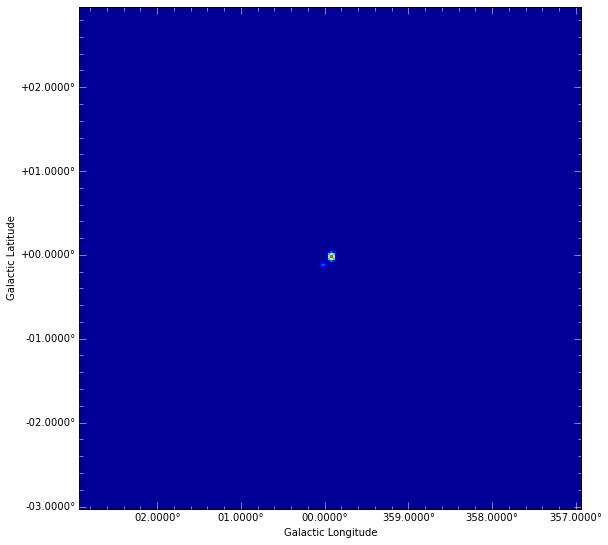

In [138]:
fig_apl = aplpy.FITSFigure(pointsource_filename)
fig_apl.show_colorscale(vmin=-1,vmax=50)
#fig_apl


<h2> Excess after subtraction of central sources

In [140]:
central_subtraction_filename = "./central_subtraction_excess.fits"
residual_skymap = excess_data - pointsource_excess 

fits.writeto(central_subtraction_filename, residual_skymap, skymap_header, clobber=True)

INFO:astropy:Auto-setting vmin to -7.502e+00
INFO:astropy:Auto-setting vmax to  9.329e+00
/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.
/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


INFO: Auto-setting vmin to -7.502e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.329e+00 [aplpy.core]


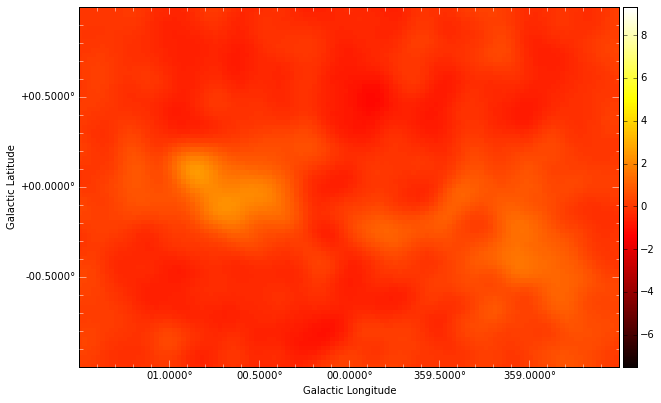

In [146]:
fig_apl = aplpy.FITSFigure(central_subtraction_filename)
fig_apl.show_colorscale( smooth=3, cmap='hot' ) #cmap='hot',
col_bar = fig_apl.show_colorbar()
fig_apl.recenter(0., 0., width=3., height=2.)


<h2> Fitting G0.9+0.1


In [ ]:
G09_bounds = {'x_mean':(81,85), 'y_mean':(123,127)}
G09_gauss = models.Gaussian2D(amplitude=20,x_mean=83,y_mean=125,x_stddev=2.,y_stddev=2.,bounds=G09_bounds)

fitter_G09 = fitting.LevMarLSQFitter()
fit_G09 = fit_p(G09_gauss, x, y, excess_data_N, maxiter=1000)

print(fit_G09.parameters)


In [ ]:
G09_filename = "./G09_excesses.fits"
G09_excess = fit_gauss(x,y)

fig_G09 = pyplot.figure()
pyplot.imshow(G09_excess)

#fits.writeto(pointsource_filename, pointsource_excess, skymap_header, clobber=False)


In [ ]:
residual_G09 = residual_skymap - G09_excess


In [ ]:
fig_residual_G09 = pyplot.figure(figsize=(10,10))
fig_residual_G09.suptitle("Sgr A* Subtracted Excess Map")
ax = fig_residual_G09.add_subplot(2,1,1)
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
pyplot.axis([50,190,80,150])
pyplot.imshow(residual_G09)
cbar = pyplot.colorbar()
#cbar.solids.set_edgecolors('face')

ax = fig_residual_G09.add_subplot(2,1,2)
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
pyplot.axis([50,190,80,150])
pyplot.imshow(residual_G09)
cbar = pyplot.colorbar()
#cbar.solids.set_edgecolors('face')


<h2>FITS figure of partially subtracted map

In [ ]:
outFilename = "./subtracted_skymap_G09.fits"

fits.writeto(outFilename, residual_G09, skymap_header, clobber=True)


<h2> Other stuff..

In [ ]:
fig_apl = aplpy.FITSFigure(outFilename)
fig_apl.show_colorscale(cmap='hot', smooth=5) # vmin=0, vmax=8
col_bar = fig_apl.show_colorbar()
#col_bar


In [ ]:

p_opt_G0901, p_cov_G0901 = optimize.curve_fit(TwoD_Gaussian, coords_world, residual_skymap.ravel(), p0=init_guess_G0901)
print(p_opt_G0901)

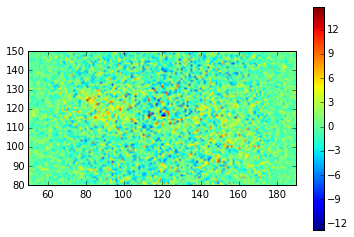

In [151]:
#fig_residual = pyplot.figure(figsize=(8,8))
fig_residual = pyplot.figure()
pyplot.axis([50,190,80,150])
pyplot.imshow(residual_skymap)
pyplot.Circle((120,120), 50)

cbar = pyplot.colorbar()
cbar.solids.set_edgecolors('face')

#fig_residual.set_axes


In [ ]:
# print(x)
# print(x_world)
# print(x_world[2,6])
# print(y_world[239,6])

print(fig_apl.pixel2world(100,180))
print(fig_apl.pixel2world(101,180))

#excess_data_N[81:85,123:127]
#xworld = fig_apl.pixel2world()

models.Gaussian2D?


fermi tools
maximum likelihood
Wilke's theorem 